# This is the final script, it makes all the regressions and the eventstudy plots

# Things to do
Hetero-plots:
- change hetro-plots to 6 weeks 
- up the font sixe on axis 
- more distance between group in the before and after
- remove line in legend in first plot
- no color in timeline (grayscale)

- full regression tables for appendix

In [1]:
#import packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm 
import scipy.stats as stats
from stargazer.stargazer import Stargazer, LineLocation
import nltk
from nltk.corpus import stopwords
import lemmy
from utils import event_plot

In [2]:
dataset = pd.read_csv("data/cleandata.csv",index_col="Unnamed: 0")


In [3]:
dateend = datetime(2021,2,4)
dstart = datetime(2020,2,26)
linde_date = datetime.strptime("2020-08-26", "%Y-%m-%d")

In [4]:
dataset['datetime'] = [datetime.strptime(d, "%Y-%m-%d") for d in dataset['datetime']]
dataset['date_clean'] = [datetime.strptime(str(d), "%Y-%m-%d") for d in dataset['date_clean']]
#dataset = dataset[dataset['datetime'] > dstart]

In [5]:
plt.rcParams.update({'font.size': 22})

In [6]:
print(len(dataset))

10192


In [7]:
#dataset.loc[dataset['sex'] == "f", 'sex'] = 0
#dataset.loc[dataset['sex'] == "m", 'sex'] = 1

In [8]:
dataset["days_from_0"] = dataset["days_till_linde"] + abs(dataset["days_till_linde"].min())

# Set y for the analysis

In [9]:
y = "std_n_women"

# I begin by making some plots for the paper

In [10]:
n_women_set = dataset.groupby('date_clean').agg({y: ['mean','sum']})
n_women_set = n_women_set[y] 

In [11]:
dates = n_women_set.index
#dates = [datetime.strptime(d, "%Y-%m-%d") for d in list(dates)]
n_women_set['dates'] = dates
n_women_set = n_women_set.reset_index(drop = True)
dateend = datetime(2020,9,1)
dstart = datetime(2020,8,20)

# Make plots

# I do an event study - 
kind of, as fixed effects do not work for me, because i have an unbalanced panel (makes it harder) and becase i want to examine differences across timeinvariant variables such as gender, which fixed effects do not allow for. 

In [12]:
#from linearmodels.panel import PanelOLS
#from linearmodels.panel import PooledOLS

In [13]:
before = dataset.groupby(['date_clean', 'treatment'])['n_women'].sum().groupby(['treatment']).mean()[0]
after = dataset.groupby(['date_clean', 'treatment'])['n_women'].sum().groupby(['treatment']).mean()[1]

n_before = dataset.groupby(['date_clean', 'treatment'])['n_women'].count().groupby(['treatment']).mean()[0]
n_after = dataset.groupby(['date_clean', 'treatment'])['n_women'].count().groupby(['treatment']).mean()[1]


In [14]:
print("Daily mean women before", before)
print("Daily mean women after", after)

print("Daily mean post before", n_before)
print("Daily mean post after", n_after)


Daily mean women before 10.685082872928177
Daily mean women after 14.25287356321839
Daily mean post before 27.099447513812155
Daily mean post after 30.385057471264368


Create some smal variables - move to datacleaning


In [15]:
plt.rcParams.update({'font.size': 30})

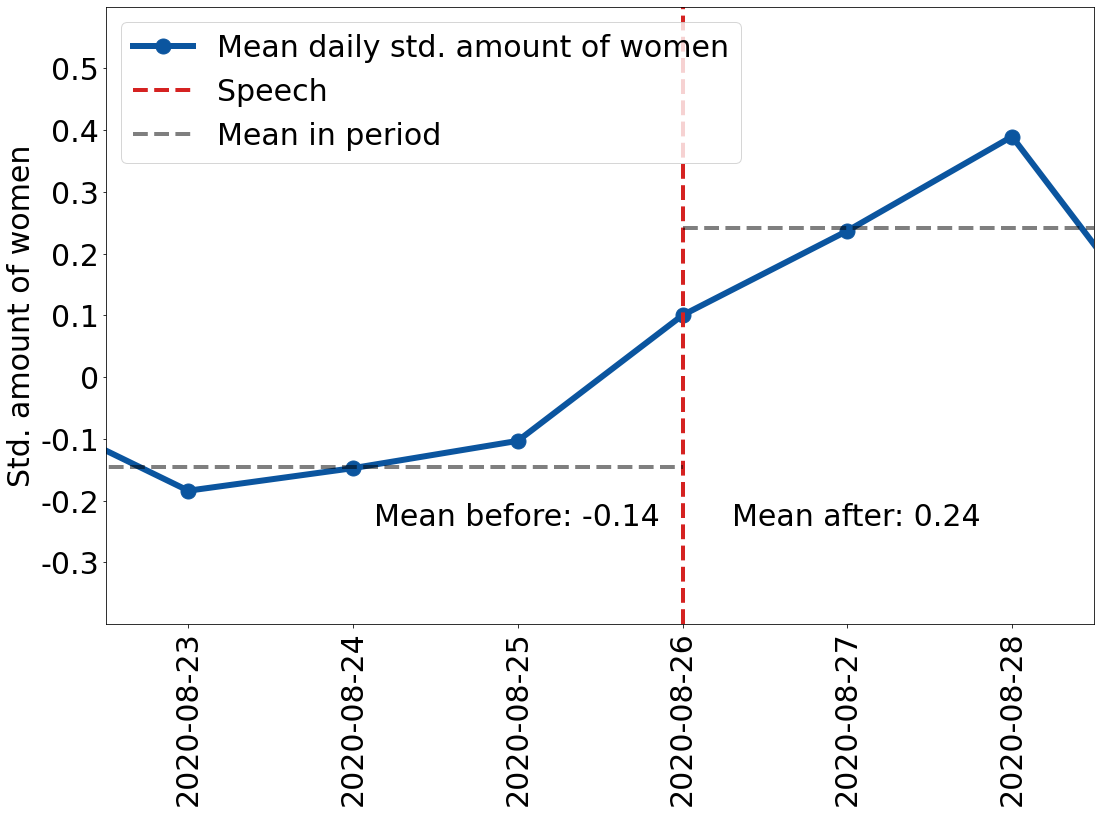

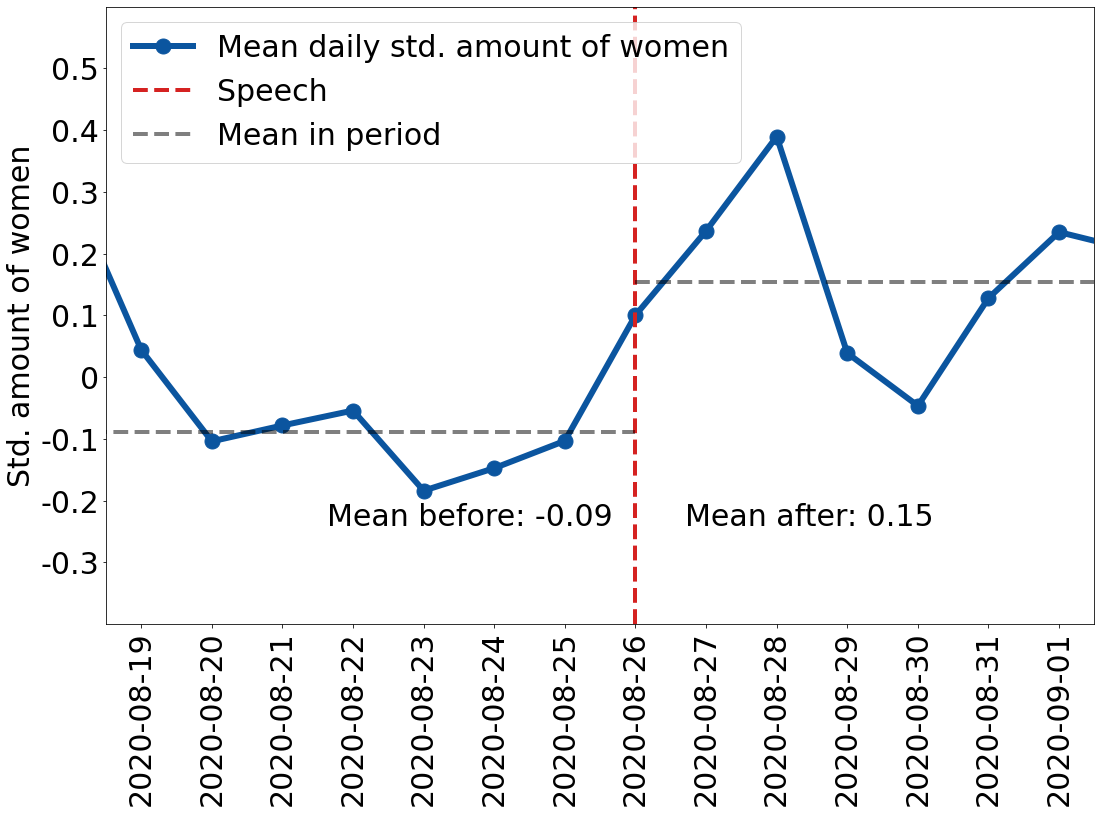

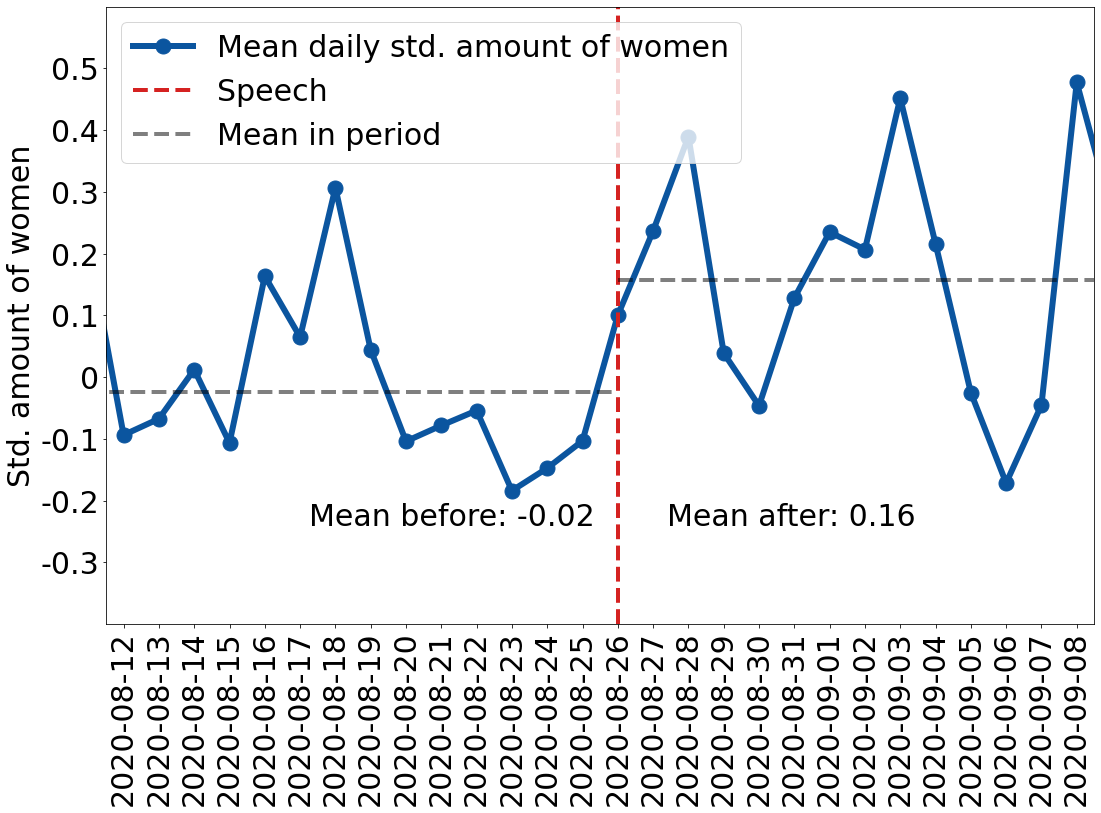

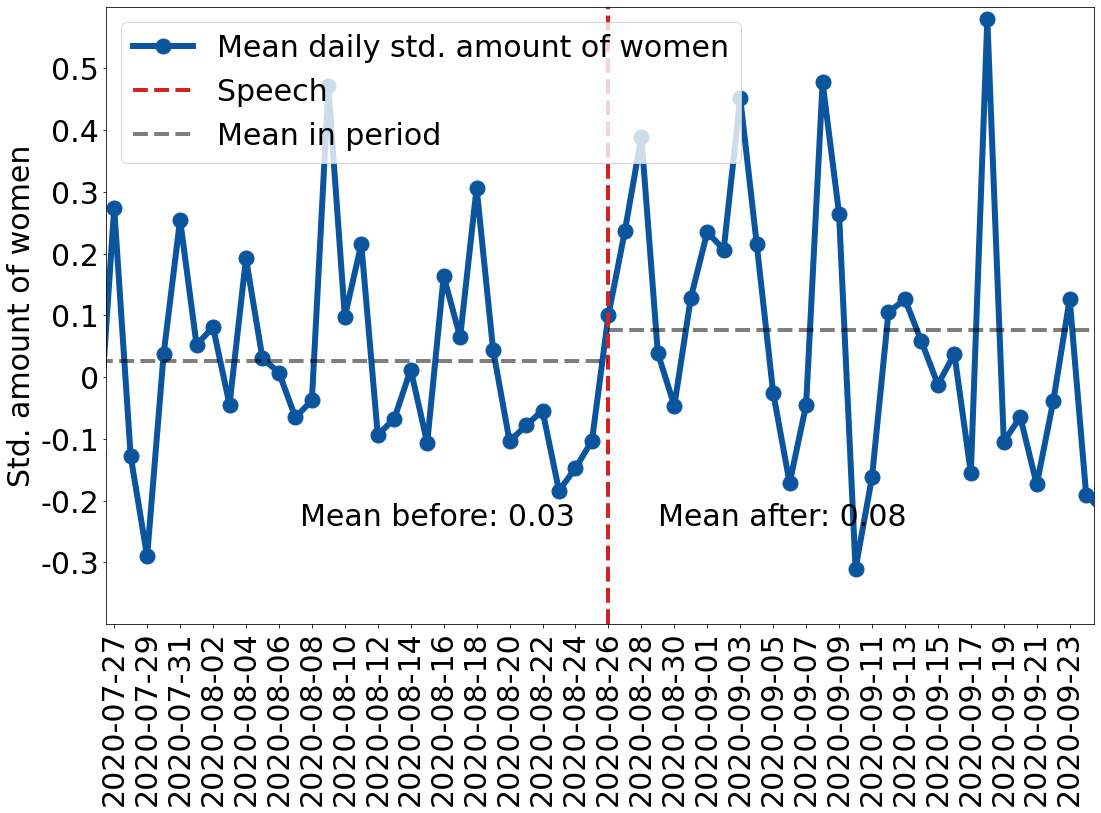

In [16]:
for p in [3,7,14,30]:

    b = dataset.groupby(['date_clean'])['std_n_women'].mean()[linde_date +timedelta(-p): linde_date+timedelta(-1)]
    a  = dataset.groupby(['date_clean'])['std_n_women'].mean()[linde_date : linde_date+timedelta(+(p-1))]
    d= list(b.index) + list(a.index)

    fig  = plt.figure(figsize=(16,12))

    plt.plot(np.sort(dataset.date_clean.unique()), 
             dataset.groupby(['date_clean'])['std_n_women'].mean(),
            label = "Mean daily std. amount of women",
            linewidth=6,
            color = "#0b559f",
            linestyle = "-",
             marker = "o",
             ms = 15)

    plt.ylabel("Std. amount of women")
    #plt.xlabel("Weeks from speech")
    plt.xticks(rotation = 90)
    
    if p >= 30:
        plt.xticks(d[0::2],[i.strftime("%Y-%m-%d") for i in d][0::2])
    else:
        
        plt.xticks(d,[i.strftime("%Y-%m-%d") for i in d])

    plt.yticks([-0.3,-0.2,-0.1,0, 0.1, 0.2,0.3,0.4,0.5],[-0.3,-0.2,-0.1,0, 0.1, 0.2,0.3,0.4,0.5])
    
    plt.xlim(linde_date +timedelta(-(p + 0.5)), linde_date +timedelta(+(p-0.5)))
    plt.ylim(-0.4,0.6)

    plt.xticks(rotation = 90)
    #plt.title("Daily mean amount of women in images")
    plt.axvline(x = linde_date, color =  '#d52221', label = 'Speech', linestyle = "--", linewidth=4) 
    #plt.axhline(, xmax = linde_date, )
    #plt.axhline(a.mean(),xmin = 0.52, linestyle='dashed', color = "black", alpha = 0.5)
    plt.plot((b.index.min() + timedelta(-1), linde_date), (b.mean(),b.mean()),
             linestyle='dashed', color = "black", alpha = 0.5, label = 'Mean in period', linewidth=4)
    plt.plot((linde_date,a.index.max() + timedelta(1), ), (a.mean(),a.mean()),
         linestyle='dashed', color = "black", alpha = 0.5, linewidth=4)

    plt.annotate(str("Mean before: " + str(round(b.mean(),2))), xy =  (linde_date + timedelta(-(2.5/4 * p)),-0.24))
    plt.annotate(str("Mean after: " + str(round(a.mean(),2))), xy =  (linde_date + timedelta((0.5/5 * p)),-0.24))

    plt.legend(loc = 'upper left')
    
    plt.tight_layout()
    filename = "plots/std_women_{}.png".format(str(p))
    plt.savefig(filename)

    plt.show()

In [17]:
plt.rcParams.update({'font.size': 22})

In [18]:
P = 30 #days to plot before an after

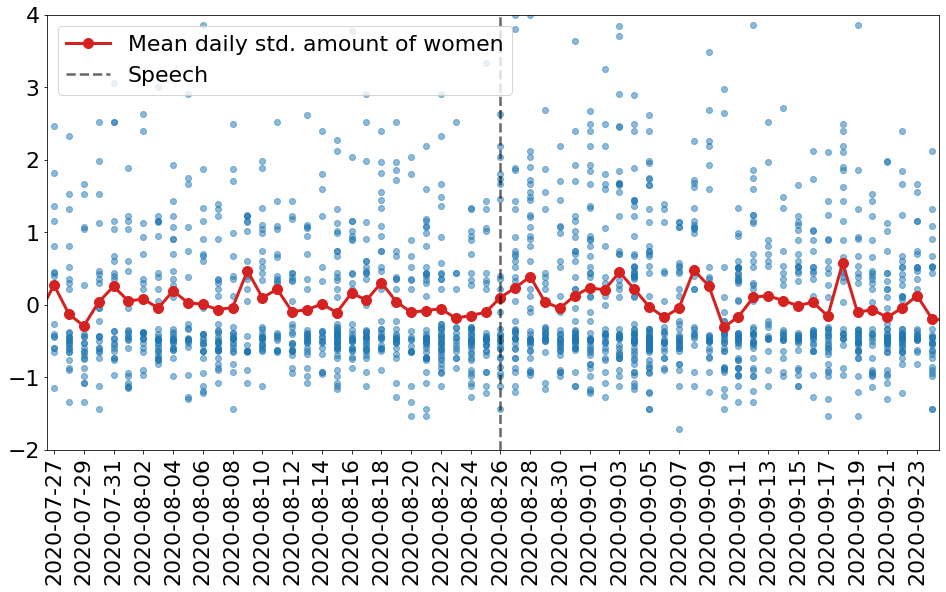

In [19]:
plt.figure(figsize=(16,8))
plt.scatter(dataset['date_clean'],
            dataset['std_n_women'],
           alpha = 0.5)
plt.plot(np.sort(dataset.date_clean.unique()), 
         dataset.groupby(['date_clean'])['std_n_women'].mean(),
        label = "Mean daily std. amount of women",
        linewidth=3,
        color = '#d52221',
        linestyle = "-",
         marker = "o",
         ms = 10)

plt.axvline(x = linde_date, color =  "black", label = 'Speech', linestyle = "--", linewidth=2.5, alpha = 0.6) 
b = dataset.groupby(['date_clean'])['std_n_women'].mean()[linde_date +timedelta(-p): linde_date+timedelta(-1)]
a  = dataset.groupby(['date_clean'])['std_n_women'].mean()[linde_date : linde_date+timedelta(+(p-1))]
d= list(b.index) + list(a.index)

if p >= 30:
    plt.xticks(d[0::2],[i.strftime("%Y-%m-%d") for i in d][0::2])
else:

    plt.xticks(d,[i.strftime("%Y-%m-%d") for i in d])



plt.xlim(linde_date +timedelta(-(p + 0.5)), linde_date +timedelta(+(p-0.5)))
plt.ylim(-2,4)

plt.xticks(rotation = 90)

plt.legend()
plt.show()

# Regressions

In [20]:
#model1 = sm.ols(formula= y + " ~  treatment" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model2 = sm.ols(formula= y + " ~ days_till_linde + treatment" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model3 = sm.ols(formula= y + " ~  days_till_linde * treatment " , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model4 = sm.ols(formula= y + " ~  treatment + week" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model5 = sm.ols(formula= y + " ~ treatment* week" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 


#stargazer = Stargazer([model1, model2, model3, model4, model5])
#stargazer.title('Basemodels')
#stargazer

### Regression table 1 - Week dummies

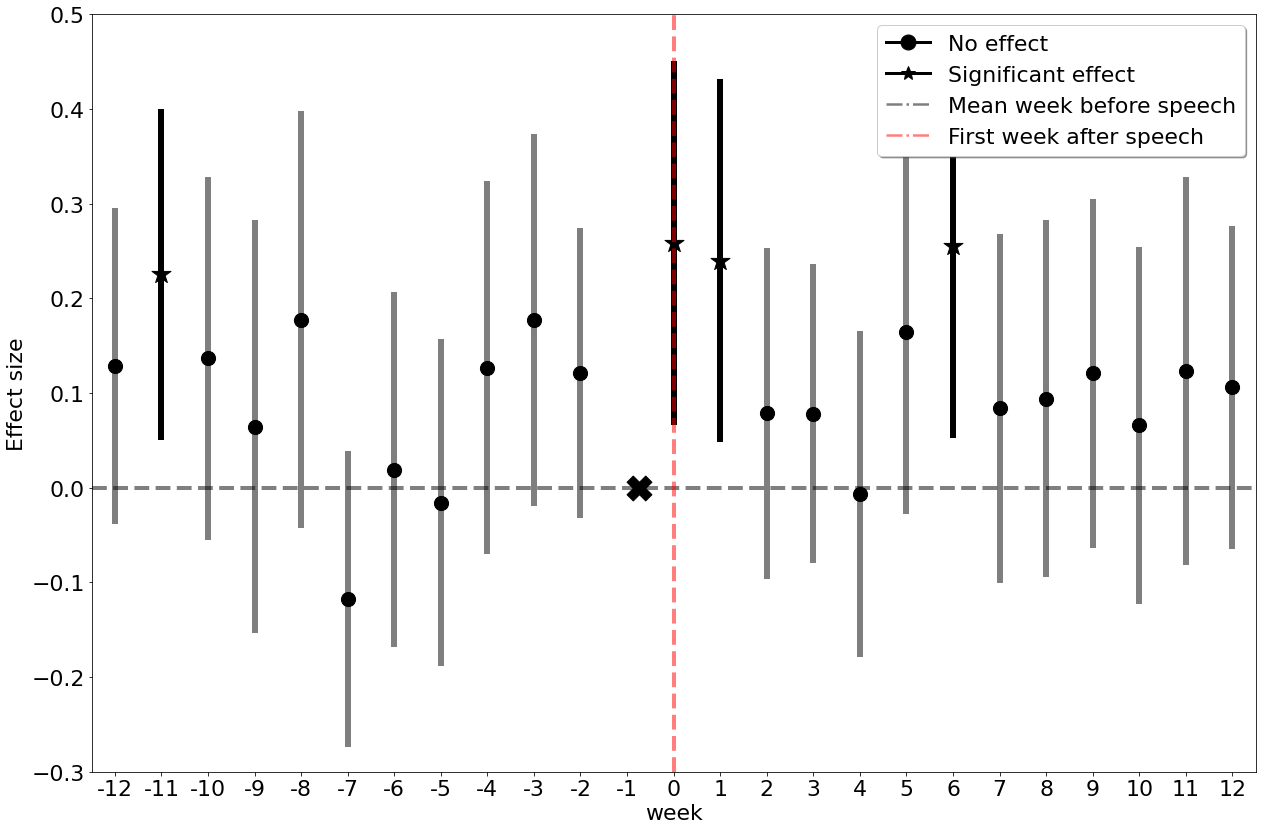

                            OLS Regression Results                            
Dep. Variable:            std_n_women   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.998
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           1.66e-10
Time:                        09:45:40   Log-Likelihood:                -14389.
No. Observations:               10192   AIC:                         2.888e+04
Df Residuals:                   10141   BIC:                         2.925e+04
Df Model:                          50                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0848      0.063     -1.348      0.1

In [21]:
df = (pd.get_dummies(dataset, columns=['week'], prefix='INX')
      .rename(columns=lambda x: x.replace('-', 'm'))
       .drop(columns='INX_m1'))

scalars = [] #add any control variables here
factors = df.columns[df.columns.str.contains('INX')] #all time periods dummies
exog = list(factors) + scalars #add control if you want
exog = '+'.join(exog) #joint them as a string
endog = y #set y to y

formula = '{} ~ {}'.format(endog, exog) #create the formula

model1 = sm.ols(formula= formula, data = df).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
#print(model1.summary())

event_plot(model1, 
       xlim1 = -12 ,
       xlim2 = 12,
       ylim1 = -0.3,
       ylim2 = 0.5,
       unit = 'week',
       save = "plots/12_weeks_event.png",
       summary = True)      

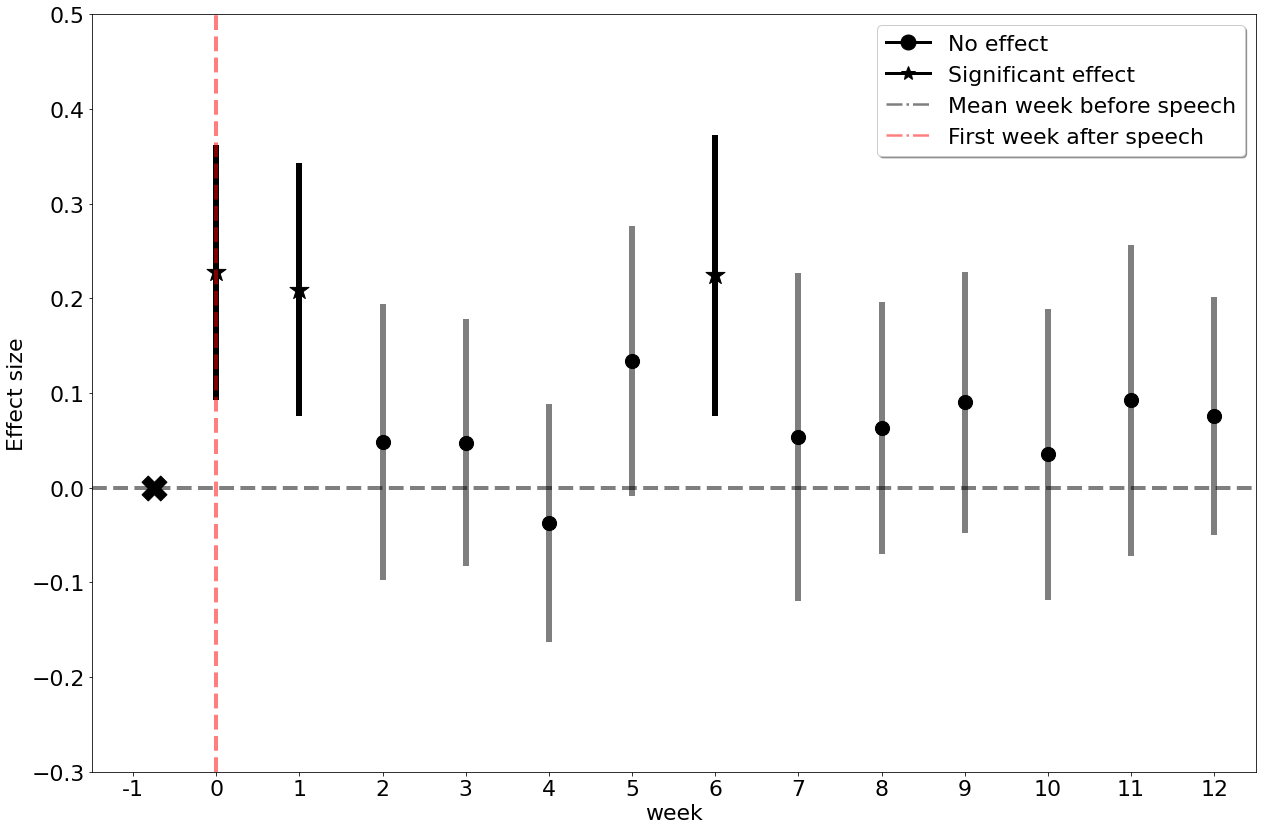

                            OLS Regression Results                            
Dep. Variable:            std_n_women   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.915
Date:                Tue, 08 Mar 2022   Prob (F-statistic):             0.0105
Time:                        09:45:42   Log-Likelihood:                -14421.
No. Observations:               10192   AIC:                         2.889e+04
Df Residuals:                   10166   BIC:                         2.908e+04
Df Model:                          25                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0541      0.013     -4.150      0.0

In [22]:
df = (pd.get_dummies(dataset, columns=['week'], prefix='INX')
      .rename(columns=lambda x: x.replace('-', 'm')))
df = df.loc[:,~df.columns.str.startswith('INX_m')] #remove all periods before the speech

scalars = [] #add any control variables here
factors = df.columns[df.columns.str.contains('INX')] #all time periods dummies
exog = list(factors) + scalars #add control if you want
exog = '+'.join(exog) #joint them as a string
endog = y #set y to y

formula = '{} ~ {}'.format(endog, exog) #create the formula

model1 = sm.ols(formula= formula, data = df).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
#print(model1.summary())

event_plot(model1, 
       xlim1 = -1 ,
       xlim2 = 12,
       ylim1 = -0.3,
       ylim2 = 0.5,
       unit = 'week',
       save = "plots/12_weeks_event_all.png",
       summary = True)      

### Regression table 2 and appendix - Experience

In [23]:
#model1 = sm.ols(formula= y + " ~  treatment" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model2 = sm.ols(formula= y + " ~  treatment + percentile" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model3 = sm.ols(formula= y + " ~  treatment* percentile " , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model4 = sm.ols(formula= y + " ~  treatment + superuser" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model5 = sm.ols(formula= y + " ~  treatment * superuser" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 




#stargazer = Stargazer([model1, model2, model3, model4, model5])
#stargazer.title('Basemodels')
#stargazer

In [24]:
model1 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) + percentile', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model2 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) *percentile', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model3 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) + superuser', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model4 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) *superuser', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})

In [25]:
print("Model 1")
print("-----------------------------------------------------------------------------------")
print(model1.summary())
print("-----------------------------------------------------------------------------------")

print("Model 2")
print("-----------------------------------------------------------------------------------")
print(model2.summary())
print("-----------------------------------------------------------------------------------")

print("Model 3")
print("-----------------------------------------------------------------------------------")
print(model3.summary())
print("-----------------------------------------------------------------------------------")

print("Model 4")
print("-----------------------------------------------------------------------------------")
print(model4.summary())
print("-----------------------------------------------------------------------------------")


Model 1
-----------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:            std_n_women   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.982
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           1.53e-10
Time:                        09:45:43   Log-Likelihood:                -14389.
No. Observations:               10192   AIC:                         2.888e+04
Df Residuals:                   10140   BIC:                         2.926e+04
Df Model:                          51                                         
Covariance Type:              cluster                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
----------

                            OLS Regression Results                            
Dep. Variable:            std_n_women   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                 3.509e+11
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:45:43   Log-Likelihood:                -14370.
No. Observations:               10192   AIC:                         2.894e+04
Df Residuals:                   10090   BIC:                         2.968e+04
Df Model:                         101                                         
Covariance Type:              cluster                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

C:\Users\tnv664\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 101, but rank is 56
  warnings.warn('covariance of constraints does not have full '


All weeks before as period -1

In [26]:
model1 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) + percentile', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model2 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) *percentile', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model3 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) + superuser', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model4 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) *superuser', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})


In [27]:
print("Model 1")
print("-----------------------------------------------------------------------------------")
print(model1.summary())
print("-----------------------------------------------------------------------------------")

print("Model 2")
print("-----------------------------------------------------------------------------------")
print(model2.summary())
print("-----------------------------------------------------------------------------------")

print("Model 3")
print("-----------------------------------------------------------------------------------")
print(model3.summary())
print("-----------------------------------------------------------------------------------")

print("Model 4")
print("-----------------------------------------------------------------------------------")
print(model4.summary())
print("-----------------------------------------------------------------------------------")


Model 1
-----------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:            std_n_women   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.886
Date:                Tue, 08 Mar 2022   Prob (F-statistic):             0.0112
Time:                        09:45:44   Log-Likelihood:                -14421.
No. Observations:               10192   AIC:                         2.890e+04
Df Residuals:                   10165   BIC:                         2.909e+04
Df Model:                          26                                         
Covariance Type:              cluster                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-----

C:\Users\tnv664\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 31
  warnings.warn('covariance of constraints does not have full '


C:\Users\tnv664\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


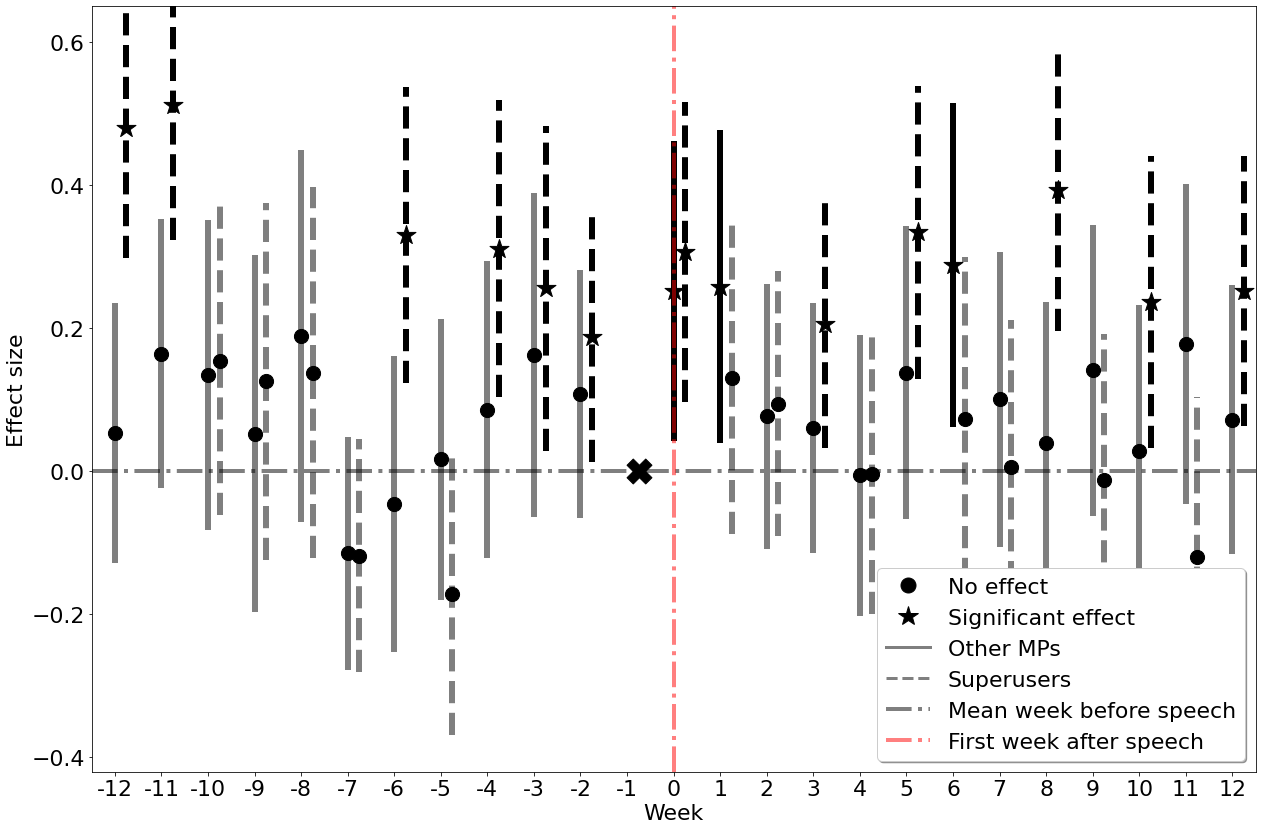

In [61]:
model1 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) *superuser', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})

plot_df = pd.concat([model1.params, model1.bse,model1.pvalues],  axis = 1)
plot_df.reset_index(inplace=True)

vars1 = ["C(week, Treatment(reference=-1))[T.{}]".format(i) for i in (range(-26,25))]
vars2 = ["C(week, Treatment(reference=-1))[T.{}]:superuser".format(i) for i in (range(-26,25))]
vars1 = plot_df[plot_df['index'].isin(vars1)]
vars2 = plot_df[plot_df['index'].isin(vars2)]

vars1.columns = ['week', 'f_parm','f_std','f_p']
vars2.columns = ['week', 'm_parm','m_std','m_p']

vars1.reset_index(drop = True, inplace = True)

vars1.loc[:,'m_parm'] = vars2['m_parm'].values
vars1.loc[:,'m_std'] = vars2['m_std'].values
vars1.loc[:,'m_p'] = vars2['m_p'].values

plot_df = vars1.copy()

plot_df.loc[:,'m_parm'] = plot_df['f_parm'] + plot_df['m_parm']

plot_df['week'] = [int(plot_df.loc[i, 'week'].split(".")[1][:-1]) for i in range(len(plot_df))]
plot_df['ci'] = plot_df['f_std']*1.96
plot_df = plot_df[['week','f_parm','f_p','m_parm','ci']]



# Plot the estimates as connected lines with error bars
plt.figure(figsize=(18,12))

    # Add a horizontal line at 0
plt.axhline(0, linestyle='-.', color = "black", alpha = 0.5, label = "Mean week before speech", linewidth=4)
plt.axvline(0, linestyle='-.', color = "red", alpha = 0.5, label = "First week after speech", linewidth=4)

for i in range(len(plot_df)):     
    f_p = plot_df.loc[i,'f_p'] #p value for the point eatimate for women (calculated using the lin. reg)
    f_parm = plot_df.loc[i,'f_parm'] #the point estimate for the women (just the param for the week, because of the interaciton term)
    m_parm = plot_df.loc[i,'m_parm'] #the point estimate for the men (the ponit  estimate for the women + the interaktion term as it is binary)
    ci = plot_df.loc[i, 'ci'] # the confidence interval (same for the two groups because they are jointly estimated)

    week = plot_df.loc[i,'week']

#plot the women
    if f_p >= 0.05  :

        er = plt.errorbar(y = f_parm, x = week, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #color women red here
                     elinewidth=6,
                     label = "No effect (Women)",
                     alpha = 0.5)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 200, marker = "o", color = 'black', alpha = 1)

    else:

        er = plt.errorbar(y = f_parm, x = week, yerr = ci, 
                     ecolor = 'black', 
                     color = 'black', 
                     elinewidth=6,
                     label = "Significant effect (Women)",
                     alpha = 1)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 400, marker = "*", color = 'black', alpha = 1)


                    #label = "Weeks with significant effect")
#plot the men
    if abs(m_parm) < ci: #if the confidence interval is larger than the parameter

        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "No effect (Men)",
                     alpha = 0.5)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week+ 0.25, s = 200, marker = "o", color = 'black', alpha = 1)

    else:


        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr = ci, 
                     #ecolor = '#d52221', 
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "Significant effect (Men)",
                         alpha = 1)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week + 0.25, s = 400, marker = "*", color = 'black', alpha = 1)


#make a big dot the week before
plt.scatter(-0.75, 0, color =  "black", s = 620,alpha = 1, marker = 'X')



# And a vertical line at the treatment time
# some versions of pandas have bug return x-axis object with data_interval
# starting at 0. In that case change 0 to 21

plt.xlim(-12.5,12.5)
plt.ylim(-0.42,0.65)
plt.xticks(list(range(-12,13)),list(range(-12,13)))

plt.xlabel('Week')
plt.ylabel("Effect size")

legs = [plt.Line2D([0], [0], marker='o',lw = 0, color = (0, 0, 0, 1), label='Scatter', markerfacecolor='black', markersize=15, alpha = 1),
        plt.Line2D([0], [0], marker='*',lw = 0, color='black', label='Scatter', markerfacecolor=(0, 0, 0, 1), markersize=20),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "-",alpha = 0.5),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "--",alpha = 0.5),
        plt.Line2D([0],[0], linestyle='-.', color = "black", alpha = 0.5, linewidth=4),
        plt.Line2D([0],[0], linestyle='-.', color = "red", alpha = 0.5, linewidth=4)]

plt.legend(legs, 
           ['No effect','Significant effect','Other MPs','Superusers',"Mean week before speech", "First week after speech"],
           loc = 'best',
           shadow=True)


plt.tight_layout()
plt.savefig("plots/week_super.png")

plt.show()

C:\Users\tnv664\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


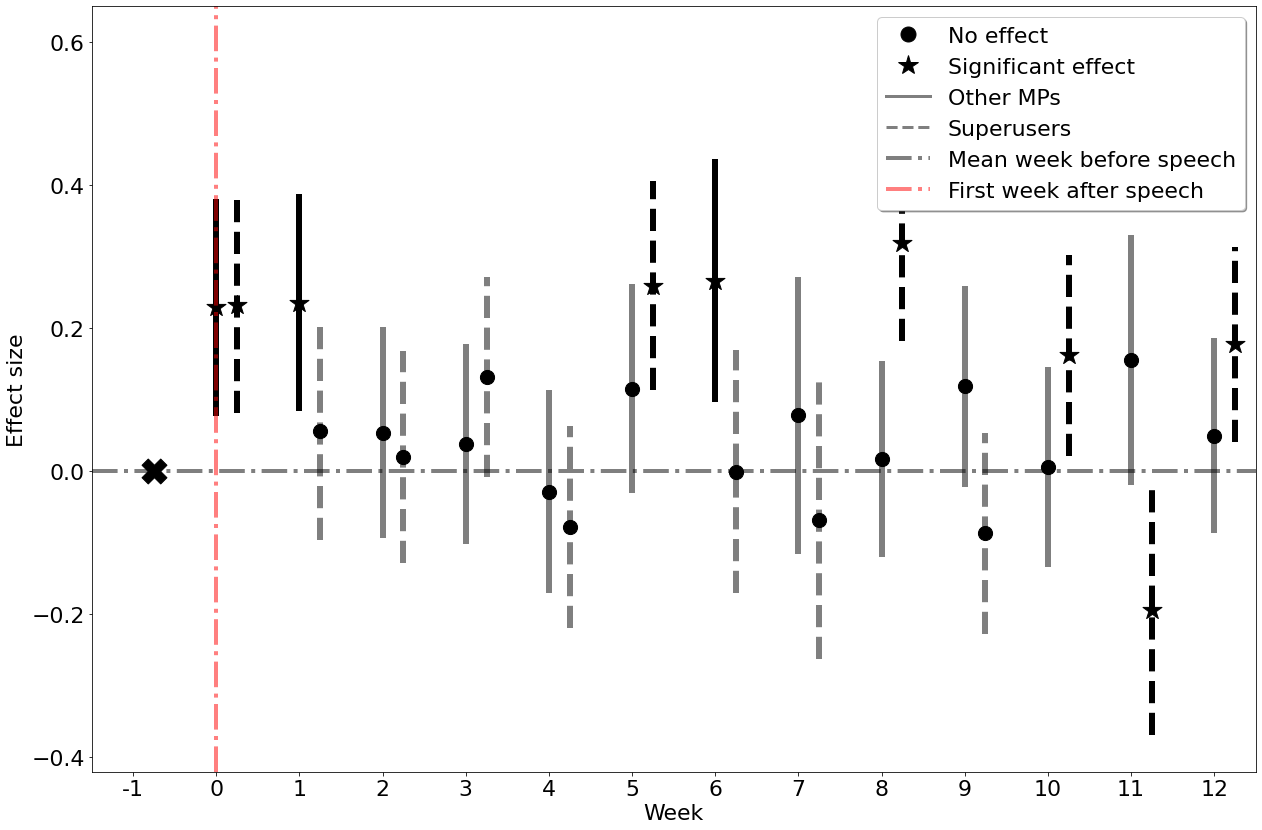

In [62]:
model1 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) *superuser', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})

plot_df = pd.concat([model1.params, model1.bse,model1.pvalues],  axis = 1)
plot_df.reset_index(inplace=True)

vars1 = ["C(week_after, Treatment(reference=-1))[T.{}]".format(i) for i in (range(-26,25))]
vars2 = ["C(week_after, Treatment(reference=-1))[T.{}]:superuser".format(i) for i in (range(-26,25))]
vars1 = plot_df[plot_df['index'].isin(vars1)]
vars2 = plot_df[plot_df['index'].isin(vars2)]

vars1.columns = ['week_after', 'f_parm','f_std','f_p']
vars2.columns = ['week_after', 'm_parm','m_std','m_p']

vars1.reset_index(drop = True, inplace = True)

vars1.loc[:,'m_parm'] = vars2['m_parm'].values
vars1.loc[:,'m_std'] = vars2['m_std'].values
vars1.loc[:,'m_p'] = vars2['m_p'].values

plot_df = vars1.copy()

plot_df.loc[:,'m_parm'] = plot_df['f_parm'] + plot_df['m_parm']

plot_df['week_after'] = [int(plot_df.loc[i, 'week_after'].split(".")[1][:-1]) for i in range(len(plot_df))]
plot_df['ci'] = plot_df['f_std']*1.96
plot_df = plot_df[['week_after','f_parm','f_p','m_parm','ci']]



# Plot the estimates as connected lines with error bars
plt.figure(figsize=(18,12))

    # Add a horizontal line at 0
plt.axhline(0, linestyle='-.', color = "black", alpha = 0.5, label = "Mean week before speech", linewidth=4)
plt.axvline(0, linestyle='-.', color = "red", alpha = 0.5, label = "First week after speech", linewidth=4)

for i in range(len(plot_df)):     
    f_p = plot_df.loc[i,'f_p'] #p value for the point eatimate for women (calculated using the lin. reg)
    f_parm = plot_df.loc[i,'f_parm'] #the point estimate for the women (just the param for the week, because of the interaciton term)
    m_parm = plot_df.loc[i,'m_parm'] #the point estimate for the men (the ponit  estimate for the women + the interaktion term as it is binary)
    ci = plot_df.loc[i, 'ci'] # the confidence interval (same for the two groups because they are jointly estimated)

    week = plot_df.loc[i,'week_after']

#plot the women
    if f_p >= 0.05  :

        er = plt.errorbar(y = f_parm, x = week, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #color women red here
                     elinewidth=6,
                     label = "No effect (Women)",
                     alpha = 0.5)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 200, marker = "o", color = 'black', alpha = 1)

    else:

        er = plt.errorbar(y = f_parm, x = week, yerr = ci, 
                     ecolor = 'black', 
                     color = 'black', 
                     elinewidth=6,
                     label = "Significant effect (Women)",
                     alpha = 1)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 400, marker = "*", color = 'black', alpha = 1)


                    #label = "Weeks with significant effect")
#plot the men
    if abs(m_parm) < ci: #if the confidence interval is larger than the parameter

        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "No effect (Men)",
                     alpha = 0.5)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week+ 0.25, s = 200, marker = "o", color = 'black', alpha = 1)

    else:


        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr = ci, 
                     #ecolor = '#d52221', 
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "Significant effect (Men)",
                         alpha = 1)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week + 0.25, s = 400, marker = "*", color = 'black', alpha = 1)


#make a big dot the week before
plt.scatter(-0.75, 0, color =  "black", s = 620,alpha = 1, marker = 'X')



# And a vertical line at the treatment time
# some versions of pandas have bug return x-axis object with data_interval
# starting at 0. In that case change 0 to 21

plt.xlim(-1.5,12.5)
plt.ylim(-0.42,0.65)
plt.xticks(list(range(-1,13)),list(range(-1,13)))

plt.xlabel('Week')
plt.ylabel("Effect size")

legs = [plt.Line2D([0], [0], marker='o',lw = 0, color = (0, 0, 0, 1), label='Scatter', markerfacecolor='black', markersize=15, alpha = 1),
        plt.Line2D([0], [0], marker='*',lw = 0, color='black', label='Scatter', markerfacecolor=(0, 0, 0, 1), markersize=20),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "-",alpha = 0.5),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "--",alpha = 0.5),
        plt.Line2D([0],[0], linestyle='-.', color = "black", alpha = 0.5, linewidth=4),
        plt.Line2D([0],[0], linestyle='-.', color = "red", alpha = 0.5, linewidth=4)]

plt.legend(legs, 
           ['No effect','Significant effect','Other MPs','Superusers',"Mean week before speech", "First week after speech"],
           loc = 'best',
           shadow=True)


plt.tight_layout()
plt.savefig("plots/week_after_super.png")

plt.show()

### Regression 3 gender and block + appendix 2

In [28]:
#model1 = sm.ols(formula= y + " ~  treatment" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model2 = sm.ols(formula= y + " ~  treatment + bloc" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model3 = sm.ols(formula= y + " ~  treatment *bloc " , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model4 = sm.ols(formula= y + " ~  treatment + sex" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model5 = sm.ols(formula= y + " ~  treatment * sex" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model6 = sm.ols(formula= y + " ~  treatment + bloc + sex " , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model7 = sm.ols(formula= y + " ~  treatment *bloc *sex" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 

#model6 = sm.ols(formula= y + " ~  days_till_linde + treatment + bloc " , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model7 = sm.ols(formula= y + " ~  days_till_linde + treatment + bloc + sex " , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model8 = sm.ols(formula= y + " ~ days_till_linde + treatment + percentile" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 
#model9 = sm.ols(formula= y + " ~  days_till_linde + treatment + superuser" , data = dataset).fit(cov_type='cluster', cov_kwds={'groups':dataset['user']}) 

#stargazer = Stargazer([model1, model2, model3, model4, model5, model6])
#stargazer.title('Basemodels')
#stargazer

In [29]:
model1 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) +bloc', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model2 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) *bloc', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model3 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) + sex', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model4 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) *sex', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})

In [30]:
print("Model 1")
print("-----------------------------------------------------------------------------------")
print(model1.summary())
print("-----------------------------------------------------------------------------------")

print("Model 2")
print("-----------------------------------------------------------------------------------")
print(model2.summary())
print("-----------------------------------------------------------------------------------")

print("Model 3")
print("-----------------------------------------------------------------------------------")
print(model3.summary())
print("-----------------------------------------------------------------------------------")

print("Model 4")
print("-----------------------------------------------------------------------------------")
print(model4.summary())
print("-----------------------------------------------------------------------------------")


Model 1
-----------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:            std_n_women   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.930
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           2.27e-10
Time:                        09:45:46   Log-Likelihood:                -14389.
No. Observations:               10192   AIC:                         2.888e+04
Df Residuals:                   10140   BIC:                         2.926e+04
Df Model:                          51                                         
Covariance Type:              cluster                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
----------

                            OLS Regression Results                            
Dep. Variable:            std_n_women   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     18.67
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           8.66e-46
Time:                        09:45:46   Log-Likelihood:                -14364.
No. Observations:               10192   AIC:                         2.893e+04
Df Residuals:                   10090   BIC:                         2.967e+04
Df Model:                         101                                         
Covariance Type:              cluster                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [31]:
model1 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) +bloc', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model2 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) *bloc', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model3 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) + sex', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model4 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) *sex', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})

In [32]:
print("Model 1")
print("-----------------------------------------------------------------------------------")
print(model1.summary())
print("-----------------------------------------------------------------------------------")

print("Model 2")
print("-----------------------------------------------------------------------------------")
print(model2.summary())
print("-----------------------------------------------------------------------------------")

print("Model 3")
print("-----------------------------------------------------------------------------------")
print(model3.summary())
print("-----------------------------------------------------------------------------------")

print("Model 4")
print("-----------------------------------------------------------------------------------")
print(model4.summary())
print("-----------------------------------------------------------------------------------")


Model 1
-----------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:            std_n_women   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.841
Date:                Tue, 08 Mar 2022   Prob (F-statistic):             0.0141
Time:                        09:45:47   Log-Likelihood:                -14421.
No. Observations:               10192   AIC:                         2.890e+04
Df Residuals:                   10165   BIC:                         2.909e+04
Df Model:                          26                                         
Covariance Type:              cluster                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-----

### Block plots


C:\Users\tnv664\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


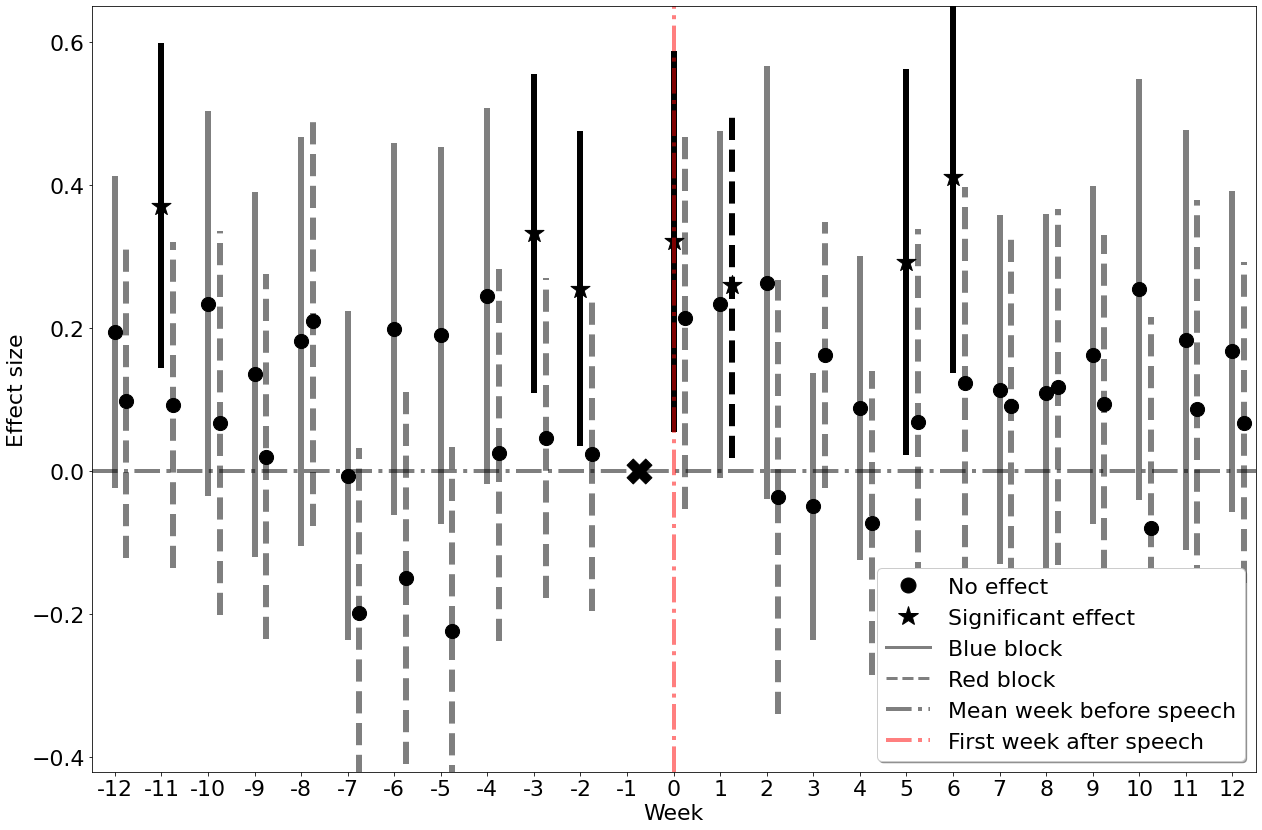

In [66]:
model1 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) *bloc', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})

plot_df = pd.concat([model1.params, model1.bse,model1.pvalues],  axis = 1)
plot_df.reset_index(inplace=True)

vars1 = ["C(week, Treatment(reference=-1))[T.{}]".format(i) for i in (range(-26,25))]
vars2 = ["C(week, Treatment(reference=-1))[T.{}]:bloc[T.r]".format(i) for i in (range(-26,25))]
vars1 = plot_df[plot_df['index'].isin(vars1)]
vars2 = plot_df[plot_df['index'].isin(vars2)]

vars1.columns = ['week', 'f_parm','f_std','f_p']
vars2.columns = ['week', 'm_parm','m_std','m_p']

vars1.reset_index(drop = True, inplace = True)

vars1.loc[:,'m_parm'] = vars2['m_parm'].values
vars1.loc[:,'m_std'] = vars2['m_std'].values
vars1.loc[:,'m_p'] = vars2['m_p'].values

plot_df = vars1.copy()

plot_df.loc[:,'m_parm'] = plot_df['f_parm'] + plot_df['m_parm']

plot_df['week'] = [int(plot_df.loc[i, 'week'].split(".")[1][:-1]) for i in range(len(plot_df))]
plot_df['ci'] = plot_df['f_std']*1.96
plot_df = plot_df[['week','f_parm','f_p','m_parm','ci']]



# Plot the estimates as connected lines with error bars
plt.figure(figsize=(18,12))

    # Add a horizontal line at 0
plt.axhline(0, linestyle='-.', color = "black", alpha = 0.5, label = "Mean week before speech", linewidth=4)
plt.axvline(0, linestyle='-.', color = "red", alpha = 0.5, label = "First week after speech", linewidth=4)

for i in range(len(plot_df)):     
    f_p = plot_df.loc[i,'f_p'] #p value for the point eatimate for women (calculated using the lin. reg)
    f_parm = plot_df.loc[i,'f_parm'] #the point estimate for the women (just the param for the week, because of the interaciton term)
    m_parm = plot_df.loc[i,'m_parm'] #the point estimate for the men (the ponit  estimate for the women + the interaktion term as it is binary)
    ci = plot_df.loc[i, 'ci'] # the confidence interval (same for the two groups because they are jointly estimated)

    week = plot_df.loc[i,'week']

#plot the women
    if f_p >= 0.05  :

        er = plt.errorbar(y = f_parm, x = week, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #color women red here
                     elinewidth=6,
                     label = "No effect (Women)",
                     alpha = 0.5)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 200, marker = "o", color = 'black', alpha = 1)

    else:

        er = plt.errorbar(y = f_parm, x = week, yerr = ci, 
                     ecolor = 'black', 
                     color = 'black', 
                     elinewidth=6,
                     label = "Significant effect (Women)",
                     alpha = 1)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 400, marker = "*", color = 'black', alpha = 1)


                    #label = "Weeks with significant effect")
#plot the men
    if abs(m_parm) < ci: #if the confidence interval is larger than the parameter

        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "No effect (Men)",
                     alpha = 0.5)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week+ 0.25, s = 200, marker = "o", color = 'black', alpha = 1)

    else:


        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr = ci, 
                     #ecolor = '#d52221', 
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "Significant effect (Men)",
                         alpha = 1)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week + 0.25, s = 400, marker = "*", color = 'black', alpha = 1)


#make a big dot the week before
plt.scatter(-0.75, 0, color =  "black", s = 620,alpha = 1, marker = 'X')



# And a vertical line at the treatment time
# some versions of pandas have bug return x-axis object with data_interval
# starting at 0. In that case change 0 to 21

plt.xlim(-12.5,12.5)
plt.ylim(-0.42,0.65)
plt.xticks(list(range(-12,13)),list(range(-12,13)))

plt.xlabel('Week')
plt.ylabel("Effect size")

legs = [plt.Line2D([0], [0], marker='o',lw = 0, color = (0, 0, 0, 1), label='Scatter', markerfacecolor='black', markersize=15, alpha = 1),
        plt.Line2D([0], [0], marker='*',lw = 0, color='black', label='Scatter', markerfacecolor=(0, 0, 0, 1), markersize=20),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "-",alpha = 0.5),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "--",alpha = 0.5),
        plt.Line2D([0],[0], linestyle='-.', color = "black", alpha = 0.5, linewidth=4),
        plt.Line2D([0],[0], linestyle='-.', color = "red", alpha = 0.5, linewidth=4)]

plt.legend(legs, 
           ['No effect','Significant effect','Blue block','Red block',"Mean week before speech", "First week after speech"],
           loc = 'best',
           shadow=True)


plt.tight_layout()
plt.savefig("plots/week_block.png")

plt.show()


In [67]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            std_n_women   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     28.70
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           1.48e-56
Time:                        14:29:25   Log-Likelihood:                -14358.
No. Observations:               10192   AIC:                         2.892e+04
Df Residuals:                   10090   BIC:                         2.966e+04
Df Model:                         101                                         
Covariance Type:              cluster                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -0.1770      0.084     -2.100      0.036      -0.342      -0.012
C(week, Treatment(reference=-1))[T.-26]               0.3305      0.156      2.123      0.034       0.025       0.636
C(week, Treatment(reference=-1))[T.-25]               0.0035      0.133      0.026      0.979      -0.258       0.265
C(week, Treatment(reference=-1))[T.-24]               0.2078      0.145      1.429      0.153      -0.077       0.493
C(week, Treatment(reference=-1))[T.-23]              -0.0193      0.111     -0.174      0.862      -0.236       0.198
C(week, Treatment(reference=-1))[T.-22]              -0.1232      0.112     -1.097      0.273      -0.343       0.097
C(week, Treatment(reference=-1))[T.-21]               0.0061      0.164      0.037      0.970      -0.314       0.327
C(week, Treatment(reference=-1))[T.-20]              -0.0912      0.100     -0.909      0.364      -0.288       0.106
C(week, Treatment(reference=-1))[T.-19]               0.0071      0.108      0.066      0.948      -0.205       0.220
C(week, Treatment(reference=-1))[T.-18]              -0.1511      0.103     -1.473      0.141      -0.352       0.050
C(week, Treatment(reference=-1))[T.-17]              -0.0559      0.115     -0.485      0.628      -0.282       0.170
C(week, Treatment(reference=-1))[T.-16]               0.2456      0.142      1.736      0.083      -0.032       0.523
C(week, Treatment(reference=-1))[T.-15]               0.1893      0.139      1.359      0.174      -0.084       0.462
C(week, Treatment(reference=-1))[T.-14]               0.1780      0.136      1.307      0.191      -0.089       0.445
C(week, Treatment(reference=-1))[T.-13]               0.0236      0.132      0.178      0.858      -0.235       0.282
C(week, Treatment(reference=-1))[T.-12]               0.1950      0.111      1.751      0.080      -0.023       0.413
C(week, Treatment(reference=-1))[T.-11]               0.3715      0.116      3.201      0.001       0.144       0.599
C(week, Treatment(reference=-1))[T.-10]               0.2343      0.137      1.709      0.088      -0.034       0.503
C(week, Treatment(reference=-1))[T.-9]                0.1358      0.130      1.042      0.297      -0.120       0.391
C(week, Treatment(reference=-1))[T.-8]                0.1818      0.146      1.244      0.213      -0.105       0.468
C(week, Treatment(reference=-1))[T.-7]               -0.0059      0.117     -0.050      0.960      -0.236       0.224
C(week, Treatment(reference=-1))[T.-6]                0.1987      0.133      1.498      0.134      -0.061       0.459
C(week, Treatment(reference=-1))[T.-5]                0.1901      0.134      1.416      0.157      -0.073       0.453
C(week, Treatme

C:\Users\tnv664\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


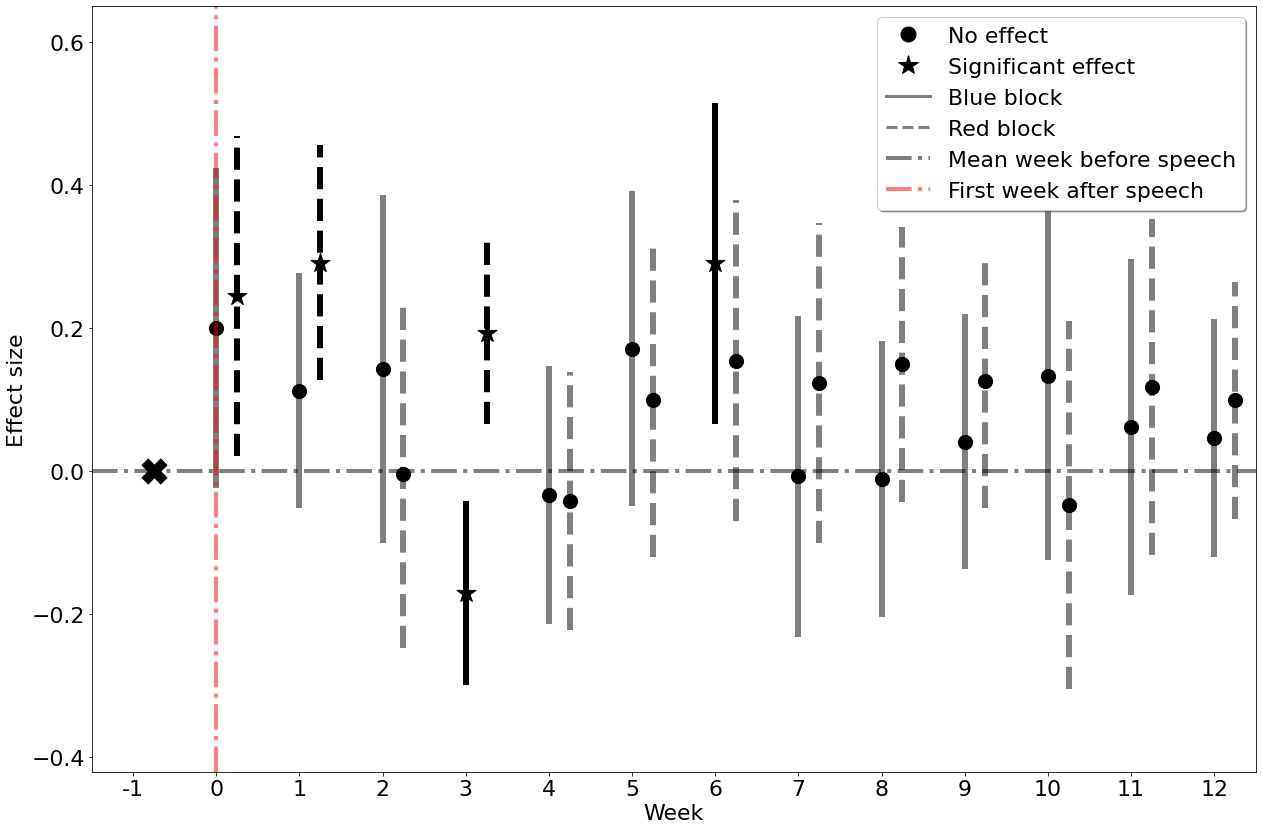

In [34]:
model1 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) *bloc', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})

plot_df = pd.concat([model1.params, model1.bse,model1.pvalues],  axis = 1)
plot_df.reset_index(inplace=True)

vars1 = ["C(week_after, Treatment(reference=-1))[T.{}]".format(i) for i in (range(-26,25))]
vars2 = ["C(week_after, Treatment(reference=-1))[T.{}]:bloc[T.r]".format(i) for i in (range(-26,25))]
vars1 = plot_df[plot_df['index'].isin(vars1)]
vars2 = plot_df[plot_df['index'].isin(vars2)]

vars1.columns = ['week_after', 'f_parm','f_std','f_p']
vars2.columns = ['week_after', 'm_parm','m_std','m_p']

vars1.reset_index(drop = True, inplace = True)

vars1.loc[:,'m_parm'] = vars2['m_parm'].values
vars1.loc[:,'m_std'] = vars2['m_std'].values
vars1.loc[:,'m_p'] = vars2['m_p'].values

plot_df = vars1.copy()

plot_df.loc[:,'m_parm'] = plot_df['f_parm'] + plot_df['m_parm']

plot_df['week_after'] = [int(plot_df.loc[i, 'week_after'].split(".")[1][:-1]) for i in range(len(plot_df))]
plot_df['ci'] = plot_df['f_std']*1.96
plot_df = plot_df[['week_after','f_parm','f_p','m_parm','ci']]



# Plot the estimates as connected lines with error bars
plt.figure(figsize=(18,12))

    # Add a horizontal line at 0
plt.axhline(0, linestyle='-.', color = "black", alpha = 0.5, label = "Mean week before speech", linewidth=4)
plt.axvline(0, linestyle='-.', color = "red", alpha = 0.5, label = "First week after speech", linewidth=4)

for i in range(len(plot_df)):     
    f_p = plot_df.loc[i,'f_p'] #p value for the point eatimate for women (calculated using the lin. reg)
    f_parm = plot_df.loc[i,'f_parm'] #the point estimate for the women (just the param for the week, because of the interaciton term)
    m_parm = plot_df.loc[i,'m_parm'] #the point estimate for the men (the ponit  estimate for the women + the interaktion term as it is binary)
    ci = plot_df.loc[i, 'ci'] # the confidence interval (same for the two groups because they are jointly estimated)

    week = plot_df.loc[i,'week_after']

#plot the women
    if f_p >= 0.05  :

        er = plt.errorbar(y = f_parm, x = week, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #color women red here
                     elinewidth=6,
                     label = "No effect (Women)",
                     alpha = 0.5)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 200, marker = "o", color = 'black', alpha = 1)

    else:

        er = plt.errorbar(y = f_parm, x = week, yerr = ci, 
                     ecolor = 'black', 
                     color = 'black', 
                     elinewidth=6,
                     label = "Significant effect (Women)",
                     alpha = 1)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 400, marker = "*", color = 'black', alpha = 1)


                    #label = "Weeks with significant effect")
#plot the men
    if abs(m_parm) < ci: #if the confidence interval is larger than the parameter

        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "No effect (Men)",
                     alpha = 0.5)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week+ 0.25, s = 200, marker = "o", color = 'black', alpha = 1)

    else:


        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr = ci, 
                     #ecolor = '#d52221', 
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "Significant effect (Men)",
                         alpha = 1)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week + 0.25, s = 400, marker = "*", color = 'black', alpha = 1)


#make a big dot the week before
plt.scatter(-0.75, 0, color =  "black", s = 620,alpha = 1, marker = 'X')



# And a vertical line at the treatment time
# some versions of pandas have bug return x-axis object with data_interval
# starting at 0. In that case change 0 to 21

plt.xlim(-1.5,12.5)
plt.ylim(-0.42,0.65)
plt.xticks(list(range(-1,13)),list(range(-1,13)))

plt.xlabel('Week')
plt.ylabel("Effect size")

legs = [plt.Line2D([0], [0], marker='o',lw = 0, color = (0, 0, 0, 1), label='Scatter', markerfacecolor='black', markersize=15, alpha = 1),
        plt.Line2D([0], [0], marker='*',lw = 0, color='black', label='Scatter', markerfacecolor=(0, 0, 0, 1), markersize=20),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "-",alpha = 0.5),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "--",alpha = 0.5),
        plt.Line2D([0],[0], linestyle='-.', color = "black", alpha = 0.5, linewidth=4),
        plt.Line2D([0],[0], linestyle='-.', color = "red", alpha = 0.5, linewidth=4)]

plt.legend(legs, 
           ['No effect','Significant effect','Blue block','Red block',"Mean week before speech", "First week after speech"],
           loc = 'best',
           shadow=True)


plt.tight_layout()
plt.savefig("plots/week_after_block.png")

plt.show()


### Gender plot

C:\Users\tnv664\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


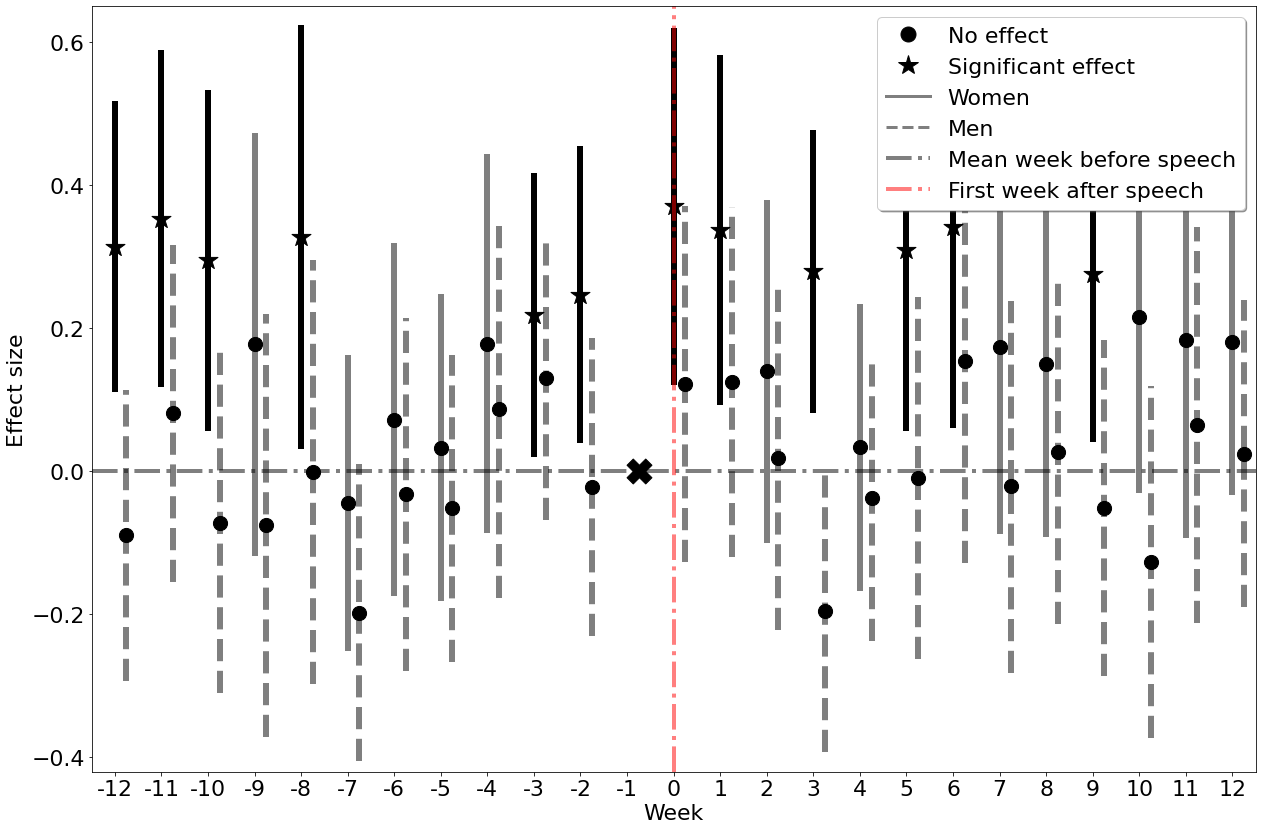

In [64]:
model1 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) *sex', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})

plot_df = pd.concat([model1.params, model1.bse,model1.pvalues],  axis = 1)
plot_df.reset_index(inplace=True)

vars1 = ["C(week, Treatment(reference=-1))[T.{}]".format(i) for i in (range(-26,25))]
vars2 = ["C(week, Treatment(reference=-1))[T.{}]:sex[T.m]".format(i) for i in (range(-26,25))]
vars1 = plot_df[plot_df['index'].isin(vars1)]
vars2 = plot_df[plot_df['index'].isin(vars2)]

vars1.columns = ['week', 'f_parm','f_std','f_p']
vars2.columns = ['week', 'm_parm','m_std','m_p']

vars1.reset_index(drop = True, inplace = True)



vars1.loc[:,'m_parm'] = vars2['m_parm'].values
vars1.loc[:,'m_std'] = vars2['m_std'].values
vars1.loc[:,'m_p'] = vars2['m_p'].values

plot_df = vars1.copy()

plot_df.loc[:,'m_parm'] = plot_df['f_parm'] + plot_df['m_parm']

plot_df['week'] = [int(plot_df.loc[i, 'week'].split(".")[1][:-1]) for i in range(len(plot_df))]
plot_df['ci'] = plot_df['f_std']*1.96
plot_df = plot_df[['week','f_parm','f_p','m_parm','ci']]




# Plot the estimates as connected lines with error bars
plt.figure(figsize=(18,12))

    # Add a horizontal line at 0
plt.axhline(0, linestyle='-.', color = "black", alpha = 0.5, label = "Mean week before speech", linewidth=4)
plt.axvline(0, linestyle='-.', color = "red", alpha = 0.5, label = "First week after speech", linewidth=4)

for i in range(len(plot_df)):     
    f_p = plot_df.loc[i,'f_p'] #p value for the point eatimate for women (calculated using the lin. reg)
    f_parm = plot_df.loc[i,'f_parm'] #the point estimate for the women (just the param for the week, because of the interaciton term)
    m_parm = plot_df.loc[i,'m_parm'] #the point estimate for the men (the ponit  estimate for the women + the interaktion term as it is binary)
    ci = plot_df.loc[i, 'ci'] # the confidence interval (same for the two groups because they are jointly estimated)
    
    week = plot_df.loc[i,'week']

#plot the women
    if f_p >= 0.05  :

        er = plt.errorbar(y = f_parm, x = week, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #color women red here
                     elinewidth=6,
                    label = "No effect (Women)",
                    alpha = 0.5)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 200, marker = "o", color = 'black', alpha = 1)

    else:

        er = plt.errorbar(y = f_parm, x = week, yerr = ci, 
                     ecolor = 'black', 
                     color = 'black', 
                     elinewidth=6,
                    label = "Significant effect (Women)",
                    alpha = 1)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 400, marker = "*", color = 'black', alpha = 1)


                    #label = "Weeks with significant effect")
#plot the men
    if abs(m_parm) < ci: #if the confidence interval is larger than the parameter

        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                    label = "No effect (Men)",
                    alpha = 0.5)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week+ 0.25, s = 200, marker = "o", color = 'black', alpha = 1)

    else:
        

        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr = ci, 
                     #ecolor = '#d52221', 
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "Significant effect (Men)",
                         alpha = 1)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week + 0.25, s = 400, marker = "*", color = 'black', alpha = 1)

            
#make a big dot the week before
plt.scatter(-0.75, 0, color =  "black", s = 620,alpha = 1, marker = 'X')



# And a vertical line at the treatment time
# some versions of pandas have bug return x-axis object with data_interval
# starting at 0. In that case change 0 to 21
plt.xlim(-12.5,12.5)
plt.ylim(-0.42,0.65)
plt.xticks(list(range(-12,13)),list(range(-12,13)))

plt.xlabel('Week')
plt.ylabel("Effect size")

legs = [plt.Line2D([0], [0], marker='o',lw = 0, color = (0, 0, 0, 1), label='Scatter', markerfacecolor='black', markersize=15, alpha = 1),
       plt.Line2D([0], [0], marker='*',lw = 0, color='black', label='Scatter', markerfacecolor=(0, 0, 0, 1), markersize=20),
       plt.Line2D([0],[0],color ='black', lw = 3, ls = "-",alpha = 0.5),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "--",alpha = 0.5),
        plt.Line2D([0],[0], linestyle='-.', color = "black", alpha = 0.5, linewidth=4),
         plt.Line2D([0],[0], linestyle='-.', color = "red", alpha = 0.5, linewidth=4)]
        

plt.legend(legs, ['No effect', 'Significant effect','Women', 'Men', "Mean week before speech","First week after speech"],
           loc = 'upper right',shadow=True)


plt.tight_layout()
plt.savefig("plots/week_gender.png")

plt.show()



C:\Users\tnv664\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


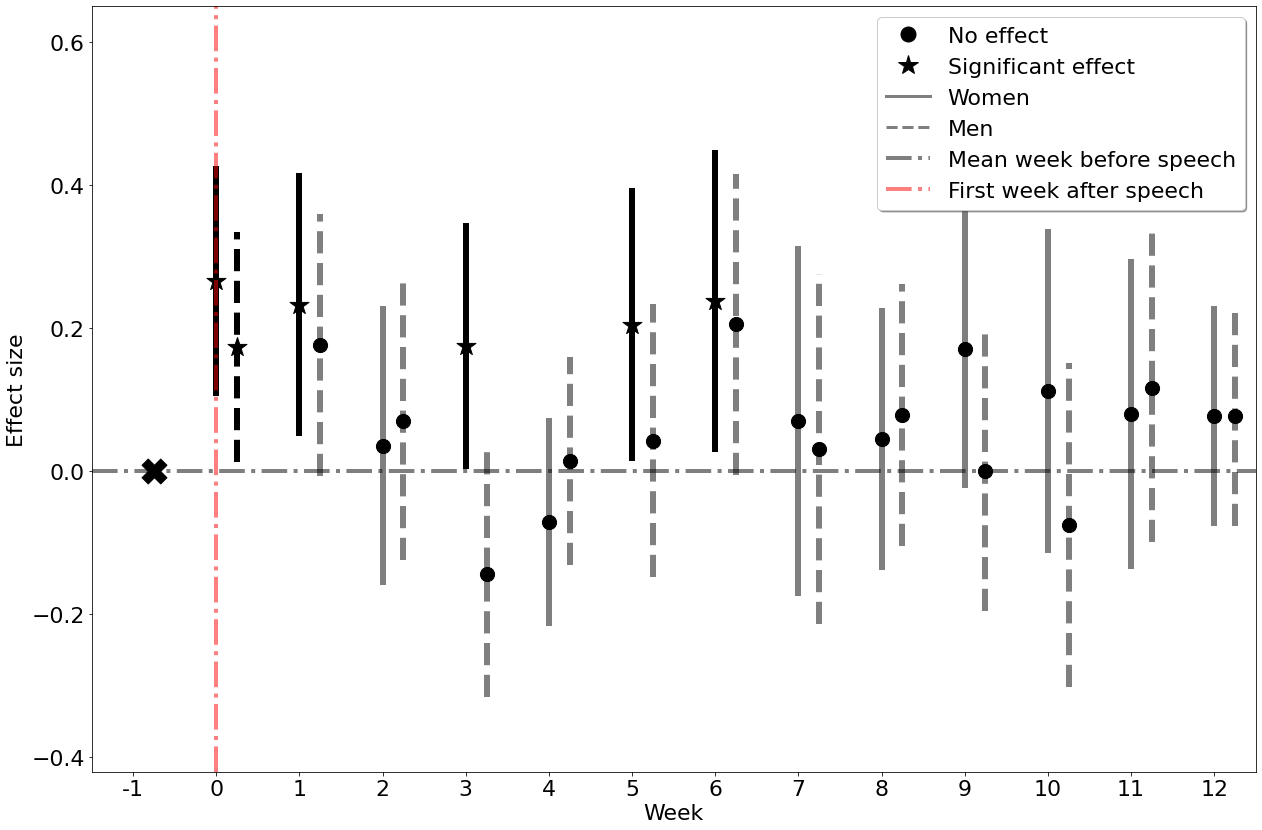

In [36]:
model1 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) *sex', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})

plot_df = pd.concat([model1.params, model1.bse,model1.pvalues],  axis = 1)
plot_df.reset_index(inplace=True)

vars1 = ["C(week_after, Treatment(reference=-1))[T.{}]".format(i) for i in (range(-26,25))]
vars2 = ["C(week_after, Treatment(reference=-1))[T.{}]:sex[T.m]".format(i) for i in (range(-26,25))]
vars1 = plot_df[plot_df['index'].isin(vars1)]
vars2 = plot_df[plot_df['index'].isin(vars2)]

vars1.columns = ['week_after', 'f_parm','f_std','f_p']
vars2.columns = ['week_after', 'm_parm','m_std','m_p']

vars1.reset_index(drop = True, inplace = True)



vars1.loc[:,'m_parm'] = vars2['m_parm'].values
vars1.loc[:,'m_std'] = vars2['m_std'].values
vars1.loc[:,'m_p'] = vars2['m_p'].values

plot_df = vars1.copy()

plot_df.loc[:,'m_parm'] = plot_df['f_parm'] + plot_df['m_parm']

plot_df['week_after'] = [int(plot_df.loc[i, 'week_after'].split(".")[1][:-1]) for i in range(len(plot_df))]
plot_df['ci'] = plot_df['f_std']*1.96
plot_df = plot_df[['week_after','f_parm','f_p','m_parm','ci']]




# Plot the estimates as connected lines with error bars
plt.figure(figsize=(18,12))

    # Add a horizontal line at 0
plt.axhline(0, linestyle='-.', color = "black", alpha = 0.5, label = "Mean week before speech", linewidth=4)
plt.axvline(0, linestyle='-.', color = "red", alpha = 0.5, label = "First week after speech", linewidth=4)

for i in range(len(plot_df)):     
    f_p = plot_df.loc[i,'f_p'] #p value for the point eatimate for women (calculated using the lin. reg)
    f_parm = plot_df.loc[i,'f_parm'] #the point estimate for the women (just the param for the week, because of the interaciton term)
    m_parm = plot_df.loc[i,'m_parm'] #the point estimate for the men (the ponit  estimate for the women + the interaktion term as it is binary)
    ci = plot_df.loc[i, 'ci'] # the confidence interval (same for the two groups because they are jointly estimated)
    
    week = plot_df.loc[i,'week_after']

#plot the women
    if f_p >= 0.05  :

        er = plt.errorbar(y = f_parm, x = week, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #color women red here
                     elinewidth=6,
                    label = "No effect (Women)",
                    alpha = 0.5)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 200, marker = "o", color = 'black', alpha = 1)

    else:

        er = plt.errorbar(y = f_parm, x = week, yerr = ci, 
                     ecolor = 'black', 
                     color = 'black', 
                     elinewidth=6,
                    label = "Significant effect (Women)",
                    alpha = 1)
        er[-1][0].set_linestyle('-')
        plt.scatter(y = f_parm, x =  week, s = 400, marker = "*", color = 'black', alpha = 1)


                    #label = "Weeks with significant effect")
#plot the men
    if abs(m_parm) < ci: #if the confidence interval is larger than the parameter

        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr =ci,
                    #label = 'Weeks with no effect',
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                    label = "No effect (Men)",
                    alpha = 0.5)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week+ 0.25, s = 200, marker = "o", color = 'black', alpha = 1)

    else:
        

        er = plt.errorbar(y = m_parm, x = week+ 0.25, yerr = ci, 
                     #ecolor = '#d52221', 
                     color = 'black', #men we will color blue here 
                     elinewidth=6,
                     label = "Significant effect (Men)",
                         alpha = 1)
        er[-1][0].set_linestyle('--')
        plt.scatter(y = m_parm, x =  week + 0.25, s = 400, marker = "*", color = 'black', alpha = 1)

            
#make a big dot the week before
plt.scatter(-0.75, 0, color =  "black", s = 620,alpha = 1, marker = 'X')



# And a vertical line at the treatment time
# some versions of pandas have bug return x-axis object with data_interval
# starting at 0. In that case change 0 to 21
plt.xlim(-1.5,12.5)
plt.ylim(-0.42,0.65)
plt.xticks(list(range(-1,13)),list(range(-1,13)))

plt.xlabel('Week')
plt.ylabel("Effect size")

legs = [plt.Line2D([0], [0], marker='o',lw = 0, color = (0, 0, 0, 1), label='Scatter', markerfacecolor='black', markersize=15, alpha = 1),
       plt.Line2D([0], [0], marker='*',lw = 0, color='black', label='Scatter', markerfacecolor=(0, 0, 0, 1), markersize=20),
       plt.Line2D([0],[0],color ='black', lw = 3, ls = "-",alpha = 0.5),
        plt.Line2D([0],[0],color ='black', lw = 3, ls = "--",alpha = 0.5),
        plt.Line2D([0],[0], linestyle='-.', color = "black", alpha = 0.5, linewidth=4),
         plt.Line2D([0],[0], linestyle='-.', color = "red", alpha = 0.5, linewidth=4)]
        

plt.legend(legs, ['No effect', 'Significant effect','Women', 'Men', "Mean week before speech","First week after speech"],
           loc = 'upper right',shadow=True)


plt.tight_layout()
plt.savefig("plots/week_after_gender.png")

plt.show()



In [65]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            std_n_women   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     18.67
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           8.66e-46
Time:                        14:28:24   Log-Likelihood:                -14364.
No. Observations:               10192   AIC:                         2.893e+04
Df Residuals:                   10090   BIC:                         2.967e+04
Df Model:                         101                                         
Covariance Type:              cluster                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -0.1734      0.083     -2.088      0.037      -0.336      -0.011
C(week, Treatment(reference=-1))[T.-26]              0.1941      0.151      1.285      0.199      -0.102       0.490
C(week, Treatment(reference=-1))[T.-25]              0.2516      0.155      1.623      0.105      -0.052       0.555
C(week, Treatment(reference=-1))[T.-24]              0.1869      0.132      1.412      0.158      -0.073       0.446
C(week, Treatment(reference=-1))[T.-23]             -0.0881      0.127     -0.693      0.488      -0.337       0.161
C(week, Treatment(reference=-1))[T.-22]             -0.1452      0.100     -1.456      0.145      -0.341       0.050
C(week, Treatment(reference=-1))[T.-21]              0.0149      0.131      0.114      0.910      -0.242       0.272
C(week, Treatment(reference=-1))[T.-20]             -0.0969      0.109     -0.893      0.372      -0.310       0.116
C(week, Treatment(reference=-1))[T.-19]             -0.1335      0.125     -1.070      0.284      -0.378       0.111
C(week, Treatment(reference=-1))[T.-18]              0.0094      0.125      0.075      0.940      -0.236       0.255
C(week, Treatment(reference=-1))[T.-17]             -0.0915      0.110     -0.829      0.407      -0.308       0.125
C(week, Treatment(reference=-1))[T.-16]              0.1282      0.135      0.947      0.343      -0.137       0.394
C(week, Treatment(reference=-1))[T.-15]              0.2009      0.122      1.645      0.100      -0.038       0.440
C(week, Treatment(reference=-1))[T.-14]              0.1626      0.112      1.450      0.147      -0.057       0.382
C(week, Treatment(reference=-1))[T.-13]              0.0608      0.147      0.414      0.679      -0.227       0.349
C(week, Treatment(reference=-1))[T.-12]              0.3142      0.104      3.030      0.002       0.111       0.517
C(week, Treatment(reference=-1))[T.-11]              0.3533      0.120      2.944      0.003       0.118       0.589
C(week, Treatment(reference=-1))[T.-10]              0.2954      0.122      2.429      0.015       0.057       0.534
C(week, Treatment(reference=-1))[T.-9]               0.1775      0.151      1.178      0.239      -0.118       0.473
C(week, Treatment(reference=-1))[T.-8]               0.3278      0.151      2.167      0.030       0.031       0.624
C(week, Treatment(reference=-1))[T.-7]              -0.0443      0.106     -0.419      0.675      -0.252       0.163
C(week, Treatment(reference=-1))[T.-6]               0.0721      0.126      0.574      0.566      -0.174       0.319
C(week, Treatment(reference=-1))[T.-5]               0.0329      0.109      0.301      0.763      -0.182       0.247
C(week, Treatment(reference=-1))[T.-4]   

## Regression table 5 - Week dummies with controls 

In [48]:
model1 = sm.ols(formula= y + ' ~ C(week, Treatment(reference=-1)) +bloc + sex + percentile', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})
model2 = sm.ols(formula= y + ' ~ C(week_after, Treatment(reference=-1)) +bloc + sex + percentile', data = dataset).fit(cov_type='cluster', cov_kwds={'groups':df['user']})


In [49]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            std_n_women   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.826
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           3.49e-10
Time:                        10:58:56   Log-Likelihood:                -14389.
No. Observations:               10192   AIC:                         2.889e+04
Df Residuals:                   10138   BIC:                         2.928e+04
Df Model:                          53                                         
Covariance Type:              cluster                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -0.0846      0.063     -1.348      0.178      -0.208       0.038
C(week, Treatment(reference=-1))[T.-26]     0.1118      0.118      0.945      0.344      -0.120       0.344
C(week, Treatment(reference=-1))[T.-25]     0.1776      0.114      1.555      0.120      -0.046       0.401
C(week, Treatment(reference=-1))[T.-24]     0.0739      0.088      0.836      0.403      -0.099       0.247
C(week, Treatment(reference=-1))[T.-23]    -0.0691      0.095     -0.726      0.468      -0.256       0.117
C(week, Treatment(reference=-1))[T.-22]    -0.1712      0.085     -2.013      0.044      -0.338      -0.005
C(week, Treatment(reference=-1))[T.-21]    -0.0372      0.101     -0.369      0.712      -0.235       0.160
C(week, Treatment(reference=-1))[T.-20]    -0.1355      0.089     -1.524      0.128      -0.310       0.039
C(week, Treatment(reference=-1))[T.-19]    -0.1079      0.092     -1.176      0.239      -0.288       0.072
C(week, Treatment(reference=-1))[T.-18]    -0.1042      0.090     -1.156      0.247      -0.281       0.072
C(week, Treatment(reference=-1))[T.-17]    -0.1201      0.077     -1.569      0.117      -0.270       0.030
C(week, Treatment(reference=-1))[T.-16]     0.1096      0.101      1.086      0.278      -0.088       0.307
C(week, Treatment(reference=-1))[T.-15]     0.1054      0.088      1.194      0.232      -0.068       0.278
C(week, Treatment(reference=-1))[T.-14]     0.0604      0.095      0.637      0.524      -0.125       0.246
C(week, Treatment(reference=-1))[T.-13]    -0.0916      0.100     -0.917      0.359      -0.287       0.104
C(week, Treatment(reference=-1))[T.-12]     0.1277      0.085      1.500      0.134      -0.039       0.295
C(week, Treatment(reference=-1))[T.-11]     0.2250      0.089      2.519      0.012       0.050       0.400
C(week, Treatment(reference=-1))[T.-10]     0.1361      0.098      1.390      0.165      -0.056       0.328
C(week, Treatment(reference=-1))[T.-9]      0.0643      0.112      0.577      0.564      -0.154       0.283
C(week, Treatment(reference=-1))[T.-8]      0.1768      0.112      1.575      0.115      -0.043       0.397
C(week, Treatment(reference=-1))[T.-7]     -0.1176      0.080     -1.476      0.140      -0.274       0.039
C(week, Treatment(reference=-1))[T.-6]      0.0185      0.096      0.193      0.847      -0.169       0.206
C(week, Treatment(reference=-1))[T.-5]     -0.0163      0.088     -0.184      0.854      -0.189       0.157
C(week, Treatment(reference=-1))[T.-4]      0.1260      0.101      1.252      0.211      -0.071       0.323
C(week, Treatment(reference=-1))[T.-3]      0.1766      0.100      1.763      0.078      -0.020       0.373
C(week, Treatment(reference=-1))[T.-2]      0.1209      0.0

In [43]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            std_n_women   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.760
Date:                Tue, 08 Mar 2022   Prob (F-statistic):             0.0187
Time:                        10:58:04   Log-Likelihood:                -14421.
No. Observations:               10192   AIC:                         2.890e+04
Df Residuals:                   10163   BIC:                         2.911e+04
Df Model:                          28                                         
Covariance Type:              cluster                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -0.0546      0.013     -4.190      0.000      -0.080      -0.029
C(week_after, Treatment(reference=-1))[T.0]      0.2281      0.069      3.320      0.001       0.093       0.363
C(week_after, Treatment(reference=-1))[T.1]      0.2095      0.068      3.061      0.002       0.075       0.344
C(week_after, Treatment(reference=-1))[T.2]      0.0487      0.074      0.654      0.513      -0.097       0.195
C(week_after, Treatment(reference=-1))[T.3]      0.0479      0.067      0.719      0.472      -0.083       0.179
C(week_after, Treatment(reference=-1))[T.4]     -0.0368      0.064     -0.571      0.568      -0.163       0.090
C(week_after, Treatment(reference=-1))[T.5]      0.1340      0.073      1.837      0.066      -0.009       0.277
C(week_after, Treatment(reference=-1))[T.6]      0.2244      0.076      2.968      0.003       0.076       0.373
C(week_after, Treatment(reference=-1))[T.7]      0.0531      0.088      0.601      0.548      -0.120       0.226
C(week_after, Treatment(reference=-1))[T.8]      0.0631      0.068      0.927      0.354      -0.070       0.196
C(week_after, Treatment(reference=-1))[T.9]      0.0904      0.070      1.288      0.198      -0.047       0.228
C(week_after, Treatment(reference=-1))[T.10]     0.0354      0.079      0.450      0.653      -0.119       0.189
C(week_after, Treatment(reference=-1))[T.11]     0.0929      0.084      1.107      0.268      -0.071       0.257
C(week_after, Treatment(reference=-1))[T.12]     0.0757      0.064      1.181      0.238      -0.050       0.201
C(week_after, Treatment(reference=-1))[T.13]     0.1768      0.082      2.166      0.030       0.017       0.337
C(week_after, Treatment(reference=-1))[T.14]     0.1531      0.083      1.849      0.064      -0.009       0.315
C(week_after, Treatment(reference=-1))[T.15]     0.0730      0.075      0.976      0.329      -0.074       0.220
C(week_after, Treatment(reference=-1))[T.16]     0.0622      0.071      0.877      0.380      -0.077       0.201
C(week_after, Treatment(reference=-1))[T.17]     0.0909      0.089      1.023      0.306      -0.083       0.265
C(week_after, Treatment(reference=-1))[T.18]     0.1550      0.092      1.678      0.093      -0.026       0.336
C(week_after, Treatment(reference=-1))[T.19]    -0.1186      0.073     -1.621      0.105      -0.262       0.025
C(week_after, Treatment(reference=-1))[T.20]     0.1265      0.073      1.722      0.085      -0.018       0.270
C(week_after, Treatment(reference=-1))[T.21]     0.1514      0.063      2.385      0.017       0.027       0.276
C(week_after, Treatment(reference=-1))[T.22]     0.1383      0.075      1.855      0.064      -0.008       0.284
C(week_after, Treatment(referenc